In [2]:
import pyprob
from pyprob import Model
from pyprob.distributions import Poisson, Categorical, Normal
import torch

import matplotlib.pyplot as plt
%matplotlib inline


In [14]:
def get_prevalence(population):
    prevalence = torch.zeros(19)
    for i in range(population.size(0)):
        # proportion of population that are alive in each age group
        age = int(population[i,0])
        if population[i,1]:
            prevalence[age] += 1
    return prevalence
            
class ToyMalaria(Model):
    def __init__(self, pop_size=10, likelihood_stddev=0.1):
        super().__init__(name='Toy Malaria')
        self.pop_size = pop_size
        self.likelihood_stddev = likelihood_stddev
    
    def forward(self):
        population = torch.zeros(self.pop_size,3)
        # 1: age ; 2: infection ; 3; vaccination
        for i in range(self.pop_size):
            age = pyprob.sample(Categorical([3.47471499, 12.7600402, 14.52151394, 12.75565434, 10.83632374, 8.393312454, 7.001421452, 5.800587654, 5.102136612, 4.182561874, 3.339409351, 2.986112356, 2.555766582, 2.332763433, 1.77400255, 1.008525491, 0.74167341, 0.271863401, 0.161614642]))
            infection = pyprob.sample(Categorical([0.5,0.5]))
            vaccination = pyprob.sample(Categorical([0.5,0.5]))
            
            population[i,0] = age
            population[i,1] = infection
            population[i,2] = vaccination
        
        prevalence = get_prevalence(population)
        likelihood_mean = prevalence
        likelihood_stddev = torch.ones_like(prevalence) * self.likelihood_stddev
        prev = pyprob.sample(Normal(likelihood_mean, likelihood_stddev), name='prevalence')
        pyprob.tag(value=population,name="population")
        return population


In [27]:
model = ToyMalaria()
prior_traces = model.prior_traces(num_traces=10000)
prior_population = prior_traces.map(lambda trace: trace.named_variables['population'].value)
prior_prevalence = prior_population.map(get_prevalence)

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:01:00 | 0d:00:00:00 | #################### | 10000/10000 | 166.37       


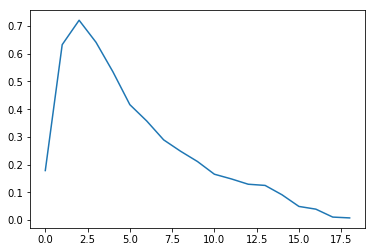

In [28]:
plt.plot(prior_prevalence.mean.numpy())

tensor([-0.0022,  0.0818,  2.1072,  0.9123, -0.1003,  0.1584,  1.0322, -0.0146,
         0.0648,  0.0060, -0.0355,  0.0245,  0.9890, -0.0489,  0.9933,  0.0035,
         0.0570, -0.0037,  0.0284])


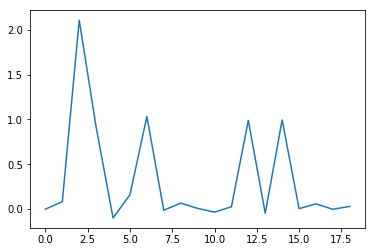

In [29]:
ground_truth_trace = next(model._trace_generator())
ground_truth_prevalence = ground_truth_trace.named_variables['prevalence'].value
print(ground_truth_prevalence)
plt.plot(ground_truth_prevalence.numpy())

## Importance sampling

In [30]:
is_posterior_traces = model.posterior_traces(observe={'prevalence': ground_truth_prevalence}, num_traces=10000)
is_posterior_population = is_posterior_traces.map(lambda trace: trace.named_variables['population'].value)
is_posterior_prevalence = is_posterior_population.map(get_prevalence)

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:01:00 | 0d:00:00:00 | #################### | 10000/10000 | 166.37       


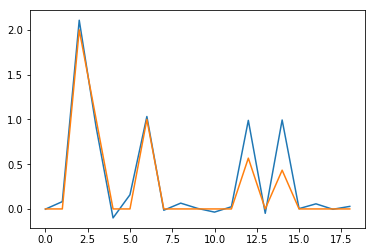

In [31]:
plt.plot(ground_truth_prevalence.numpy())
plt.plot(is_posterior_prevalence.mean.numpy())

## Random-walk Metropolis Hastings

In [32]:
rmh_posterior_traces = model.posterior_traces(observe={'prevalence': ground_truath_prevalence}, num_traces=10000, inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS)
rmh_posterior_population = rmh_posterior_traces.map(lambda trace: trace.named_variables['population'].value)[1000:]
rmh_posterior_prevalence = rmh_posterior_population.map(get_prevalence)

Time spent  | Time remain.| Progress             | Trace       | Accepted|Smp reuse| Traces/sec
0d:00:01:20 | 0d:00:00:00 | #################### | 10000/10000 |  65.96% |  96.67% | 124.62       


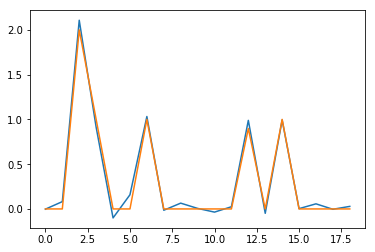

In [33]:
plt.plot(ground_truth_prevalence.numpy())
plt.plot(rmh_posterior_prevalence.mean.numpy())

## Inference compilation (importance sampling with learned proposals)

In [37]:
model.reset_inference_network()
model.learn_inference_network(num_traces=1000, observe_embeddings={'prevalence': {}})

Creating new inference network...
Observable prevalence: reshape not specified, using shape torch.Size([19]).
Observable prevalence: embedding dim not specified, using the default 256.
Observable prevalence: observe embedding not specified, using the default FEEDFORWARD.
Observable prevalence: embedding depth not specified, using the default 2.
Observe embedding dimension: 256
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 78__forward__age__Categorical(len_probs:19)__1, distribution: Categorical
New layers, address: 96__forward__infection__Categorical(len_probs:2)__..., distribution: Categorical
New layers, address: 114__forward__vaccination__Categorical(len_probs:2..., distribution: Categorical
New layers, address: 78__forward__age__Categorical(len_probs:19)__2, distribution: Categorical
New layers, address: 96__forward__infection__Categorical(len_probs:2)__..., distribution: Categorical
New layers, addres

RuntimeError: The expanded size of the tensor (10) must match the existing size (19) at non-singleton dimension 1.  Target sizes: [64, 10].  Tensor sizes: [64, 19]

In [ ]:
ic_posterior_traces = model.posterior_traces(observe={'prevalence': ground_truth_prevalence}, num_traces=10000, inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK)
ic_posterior_population = ic_posterior_traces.map(lambda trace: trace.named_variables['population'].value)
ic_posterior_prevalence = ic_posterior_population.map(get_prevalence)